# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

import patsy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
%matplotlib inline

In [2]:
# Carregar os dados
df = pd.read_csv('previsao_de_renda.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   index                  15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12466 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  mau                    15000 non-null  bool   
 15  re

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [4]:
# Tratando os dados
# 1. retirando colunas desnecessarias
df = df.drop(columns=['data_ref'])

In [5]:
# 2. Tratar variáveis categóricas com One-Hot Encoding
df = pd.get_dummies(df, columns=['sexo', 'tipo_renda','educacao', 'estado_civil', 'tipo_residencia'], drop_first=True)

In [6]:
# 3. Tratar variáveis booleanas (converter para 0 e 1)
df['posse_de_veiculo'] = df['posse_de_veiculo'].astype(int)
df['posse_de_imovel'] = df['posse_de_imovel'].astype(int)
df['mau'] = df['mau'].astype(int)

In [7]:
# 4. Tratar valores ausentes (NaN) na variável 'tempo_emprego', Preenchendo valores ausentes com a mediana da coluna
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())


In [8]:
# Separando a base de dados
X = df.drop(columns=['renda', 'index'], axis=1)  
y = df['renda']               

# Separando em 75% treinamento e 25% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Exibindo os tamanhos dos conjuntos
print(f'Tamanho do conjunto de treinamento: {X_train.shape[0]} amostras')
print(f'Tamanho do conjunto de teste: {X_test.shape[0]} amostras')

Tamanho do conjunto de treinamento: 11250 amostras
Tamanho do conjunto de teste: 3750 amostras


In [9]:
# regularização ridge com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] 

# Definindo o intervalo de valores para alpha
alphas = np.array([0, 0.001, 0.005, 0.01, 0.05, 0.1])

# Criando o modelo Ridge
ridge = Ridge()

# Configurando a busca em grade (GridSearch) para encontrar o melhor valor de alpha
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge, param_grid, cv=5)  # cv=5 para 5-fold cross-validation

# Ajustando o modelo com os dados de treino (X_train, y_train)
grid_search.fit(X_train, y_train)

# Imprimindo o melhor valor de alpha encontrado
print(f'Melhor valor de alpha: {grid_search.best_params_["alpha"]}')
print(f'Melhor score: {grid_search.best_score_}')
best_ridge = grid_search.best_estimator_
print(f'Melhor ridge: {grid_search.best_estimator_}')

Melhor valor de alpha: 0.1
Melhor score: 0.20591057506847793
Melhor ridge: Ridge(alpha=0.1)


In [10]:
# regressão LASSO

# Remover alpha=0 do intervalo
alphas = np.array([0.001, 0.005, 0.01, 0.05, 0.1])

# Criando o modelo Lasso
lasso = Lasso(max_iter=10000)  # Aumentando o número de iterações

# Escalonando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Configurando a busca em grade (GridSearch) para encontrar o melhor valor de alpha
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(lasso, param_grid, cv=5)  # cv=5 para 5-fold cross-validation

# Ajustando o modelo com os dados escalonados
grid_search.fit(X_train_scaled, y_train)

# Imprimindo o melhor valor de alpha encontrado
print(f'Melhor valor de alpha: {grid_search.best_params_["alpha"]}')
print(f'Melhor score: {grid_search.best_score_}')
best_ridge = grid_search.best_estimator_
print(f'Melhor ridge: {grid_search.best_estimator_}')


Melhor valor de alpha: 0.1
Melhor score: 0.20591305726193596
Melhor ridge: Lasso(alpha=0.1, max_iter=10000)


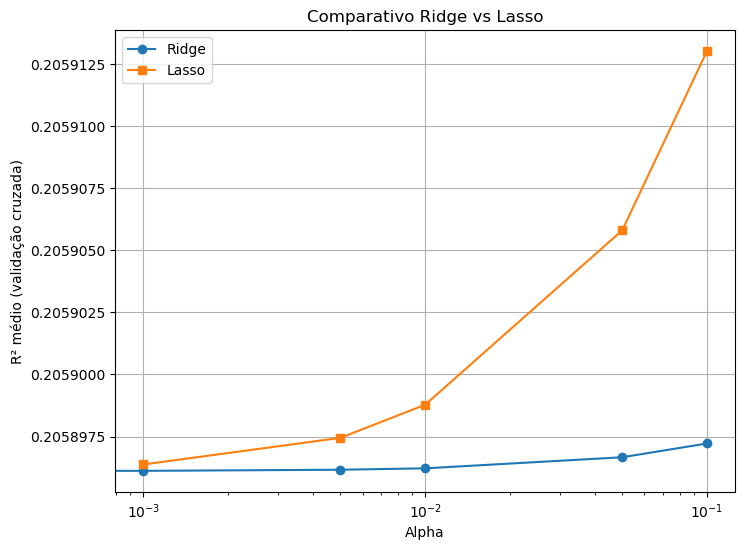

Ridge -> Melhor alpha: 0.1  | Score: 0.2058972193239232
Lasso -> Melhor alpha: 0.1  | Score: 0.2059130275474649


In [11]:
# Comparando modelos Ridge e Lasso:

# Intervalo de alphas
alphas_ridge = np.array([0, 0.001, 0.005, 0.01, 0.05, 0.1])
alphas_lasso = np.array([0.001, 0.005, 0.01, 0.05, 0.1])

# --- Ridge ---
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
param_grid_ridge = {'ridge__alpha': alphas_ridge}
grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=5, scoring='r2', return_train_score=True)
grid_ridge.fit(X_train, y_train)

# --- Lasso ---
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])
param_grid_lasso = {'lasso__alpha': alphas_lasso}
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='r2', return_train_score=True)
grid_lasso.fit(X_train, y_train)

# Resultados
mean_scores_ridge = grid_ridge.cv_results_['mean_test_score']
mean_scores_lasso = grid_lasso.cv_results_['mean_test_score']

# Plot comparativo
plt.figure(figsize=(8,6))
plt.plot(alphas_ridge, mean_scores_ridge, marker='o', label='Ridge')
plt.plot(alphas_lasso, mean_scores_lasso, marker='s', label='Lasso')
plt.xscale('log')  # escala logarítmica ajuda a visualizar
plt.xlabel('Alpha')
plt.ylabel('R² médio (validação cruzada)')
plt.title('Comparativo Ridge vs Lasso')
plt.legend()
plt.grid(True)
plt.show()

# Melhor alpha e score
print("Ridge -> Melhor alpha:", grid_ridge.best_params_['ridge__alpha'], 
      " | Score:", grid_ridge.best_score_)
print("Lasso -> Melhor alpha:", grid_lasso.best_params_['lasso__alpha'], 
      " | Score:", grid_lasso.best_score_)

A diferença entre eles é de 0.0000158, ou seja, absolutamente irrelevante do ponto de vista prático. 
Os dois modelos têm praticamente o mesmo poder preditivo nos seus dados.

In [12]:
# Stepwise

# Preenchendo NaNs e convertendo para float
X = X.astype(float).fillna(X.mean())
y = y.astype(float).fillna(y.mean())

# Se houver categóricas:
X = pd.get_dummies(X, drop_first=True)

In [13]:
# Função para adicionar uma constante ao modelo (intercepto)
def add_constant(X):
    return sm.add_constant(X)

# Stepwise otimizado (forward + backward)
def stepwise_selection_fast(X, y, threshold_in=0.05, threshold_out=0.1, verbose=True):
    included = []
    remaining = list(X.columns)
    
    while True:
        changed = False
        
        # --- Forward step ---
        if remaining:
            # Ajusta modelo com cada feature restante de forma vetorizada
            pvals = pd.Series(index=remaining, dtype=float)
            for feature in remaining:
                model = sm.OLS(y, add_constant(X[included + [feature]])).fit()
                pvals[feature] = model.pvalues[feature]
            
            best_pval = pvals.min()
            if best_pval < threshold_in:
                best_feature = pvals.idxmin()
                included.append(best_feature)
                remaining.remove(best_feature)
                changed = True
                if verbose:
                    print(f"Adicionando {best_feature} com p-valor {best_pval:.4f}")
        
        # --- Backward step ---
        if included:
            model = sm.OLS(y, add_constant(X[included])).fit()
            pvalues = model.pvalues.drop("const")
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                remaining.append(worst_feature)
                changed = True
                if verbose:
                    print(f"Removendo {worst_feature} com p-valor {worst_pval:.4f}")
        
        # Se não houver mudanças, encerra
        if not changed:
            break
    
    return included


# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Aplicando Stepwise 
best_features = stepwise_selection_fast(X_train, y_train, threshold_in=0.05, threshold_out=0.1, verbose=True)
print("\nVariáveis selecionadas:", best_features)

# Ajustando um modelo final
X_train_best = add_constant(X_train[best_features])
model = sm.OLS(y_train, X_train_best).fit()

X_test_best = add_constant(X_test[best_features])
y_pred = model.predict(X_test_best)

# Avaliar desempenho
r2 = r2_score(y_test, y_pred)
print("R² no conjunto de teste:", r2)


Adicionando tempo_emprego com p-valor 0.0000
Adicionando sexo_M com p-valor 0.0000
Adicionando tipo_renda_Empresário com p-valor 0.0000
Adicionando educacao_Superior completo com p-valor 0.0000
Adicionando posse_de_imovel com p-valor 0.0000
Adicionando idade com p-valor 0.0000
Adicionando tipo_renda_Servidor público com p-valor 0.0000
Adicionando tipo_renda_Pensionista com p-valor 0.0008
Adicionando educacao_Pós graduação com p-valor 0.0035
Adicionando tipo_residencia_Governamental com p-valor 0.0494

Variáveis selecionadas: ['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior completo', 'posse_de_imovel', 'idade', 'tipo_renda_Servidor público', 'tipo_renda_Pensionista', 'educacao_Pós graduação', 'tipo_residencia_Governamental']
R² no conjunto de teste: 0.22858036925945535


O conjunto indica que o modelo consegue explicar cerca de 22,8% da variabilidade da variável alvo com as variáveis selecionadas pelo stepwise. R² no conjunto de teste: 0.22858036925945535
Ele foi oque obteve o melhor resultado nos conjuntos de teste.


In [14]:
# Modelo final com as variáveis selecionadas
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

# Ajustando o modelo OLS final
X_train_const = add_constant(X_train_best)
model = sm.OLS(y_train, X_train_const).fit()

# Avaliando o modelo nos dados de teste
X_test_const = add_constant(X_test_best)
y_pred = model.predict(X_test_const)
r2 = r2_score(y_test, y_pred)

# Exibindo o resultado final
print(f'Variáveis selecionadas: {best_features}')
print(f'R² no conjunto de teste: {r2}')


Variáveis selecionadas: ['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior completo', 'posse_de_imovel', 'idade', 'tipo_renda_Servidor público', 'tipo_renda_Pensionista', 'educacao_Pós graduação', 'tipo_residencia_Governamental']
R² no conjunto de teste: 0.22858036925945535


In [15]:

# Garantindo que todas as colunas de X sejam do tipo float
X = X.astype(float)

# Garantindo que y seja do tipo float
y = y.astype(float)

# Função de seleção stepwise
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.05,
                       threshold_out=0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        # começamos pela lista de variaveis excluidas
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=np.float64)
        # para que toda variavel excluida vá sendo incluida e o p-value armazenado
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        # vai retirando as váriaveis menos significantes
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Executando a seleção stepwise
variaveis = stepwise_selection(X, y)

print('resulting features:')
print(variaveis)




Add  tempo_emprego                  with p-value 0.0
Add  sexo_M                         with p-value 8.88722e-208
Add  tipo_renda_Empresário          with p-value 2.74091e-35
Add  educacao_Superior completo     with p-value 1.07778e-15
Add  posse_de_imovel                with p-value 5.9332e-10
Add  idade                          with p-value 1.32972e-06
Add  tipo_renda_Pensionista         with p-value 4.02303e-05
Add  tipo_renda_Servidor público    with p-value 0.000657204
Add  educacao_Pós graduação         with p-value 0.00827478
Add  tipo_residencia_Casa           with p-value 0.00986853
resulting features:
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior completo', 'posse_de_imovel', 'idade', 'tipo_renda_Pensionista', 'tipo_renda_Servidor público', 'educacao_Pós graduação', 'tipo_residencia_Casa']


In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Criar o modelo de árvore de regressão
tree = DecisionTreeRegressor(random_state=42)

# Ajustar o modelo
tree.fit(X_train, y_train)

# Previsões no teste
y_pred = tree.predict(X_test)

# Avaliar R²
r2 = r2_score(y_test, y_pred)
print("R² no conjunto de teste (árvore de regressão):", r2)

R² no conjunto de teste (árvore de regressão): -0.3436683029407537


In [17]:
tree = DecisionTreeRegressor(
    max_depth=5,         # profundidade máxima
    min_samples_leaf=5,  # mínimo de amostras em cada folha
    random_state=42
)
# Ajustar o modelo
tree.fit(X_train, y_train)

# Previsões no teste
y_pred = tree.predict(X_test)

# Avaliar R²
r2 = r2_score(y_test, y_pred)
print("R² no conjunto de teste (árvore de regressão):", r2)

R² no conjunto de teste (árvore de regressão): 0.225391704151523


In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Definir modelo base
tree = DecisionTreeRegressor(random_state=42)

# Definir grid de hiperparâmetros
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 3, 5, 10]
}

# GridSearch com 5-fold cross-validation
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Melhor modelo
best_tree = grid_search.best_estimator_

# Previsões no teste
y_pred = best_tree.predict(X_test)

# Avaliar R²
r2 = r2_score(y_test, y_pred)

print("Melhores hiperparâmetros da árvore:", grid_search.best_params_)
print("R² no conjunto de teste (árvore otimizada):", r2)


Melhores hiperparâmetros da árvore: {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
R² no conjunto de teste (árvore otimizada): 0.20544451123878138


Mediana real da renda: 3217.48
Mediana prevista pelo modelo: 4460.59
Erro percentual da mediana: 38.64%

--- RidgeCV ---
Melhor alpha encontrado: 10.0
R² no conjunto de teste: 0.2283


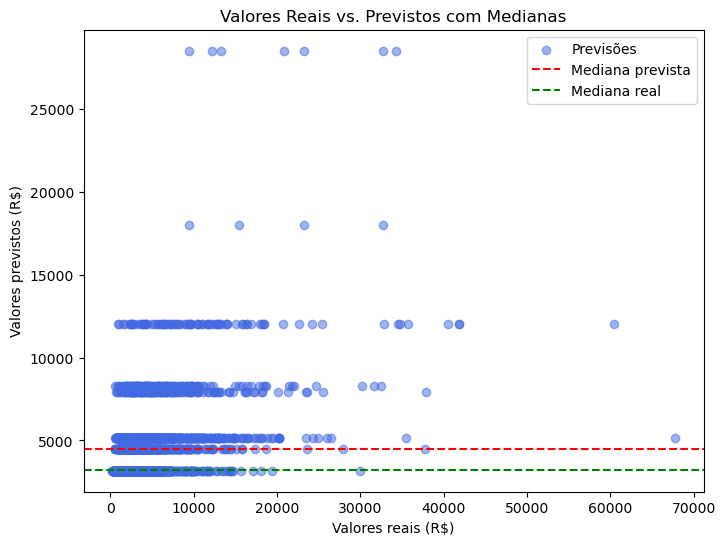

In [20]:

# 1. Comparar a mediana prevista vs real

y_pred = best_tree.predict(X_test)

mediana_real = np.median(y_test)
mediana_prevista = np.median(y_pred)

print(f"Mediana real da renda: {mediana_real:.2f}")
print(f"Mediana prevista pelo modelo: {mediana_prevista:.2f}")
print(f"Erro percentual da mediana: {100 * (mediana_prevista - mediana_real) / mediana_real:.2f}%")

# 2. RidgeCV para melhor ajuste

alphas = [0.01, 0.1, 1, 10, 100, 1000]

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

y_pred_ridge = ridge_cv.predict(X_test)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\n--- RidgeCV ---")
print(f"Melhor alpha encontrado: {ridge_cv.alpha_}")
print(f"R² no conjunto de teste: {r2_ridge:.4f}")


# 3. Gráfico de valores reais vs previstos

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Previsões", color="royalblue")
plt.axhline(mediana_prevista, color="red", linestyle="--", label="Mediana prevista")
plt.axhline(mediana_real, color="green", linestyle="--", label="Mediana real")
plt.xlabel("Valores reais (R$)")
plt.ylabel("Valores previstos (R$)")
plt.title("Valores Reais vs. Previstos com Medianas")
plt.legend()
plt.show()


In [21]:
diferenca_perc = (mediana_prevista - mediana_real) / mediana_real * 100
print(f"Diferença percentual: {diferenca_perc:.2f}%")


Diferença percentual: 38.64%


Conclusão do Projeto – Previsão de Renda

A Regressão Ridge e a Lasso tiveram desempenhos semelhantes (R² ≈ 0,21), sem diferença prática relevante.

O modelo Stepwise alcançou melhor resultado (R² ≈ 0,228), indicando boa seleção de variáveis.

A Árvore de Regressão otimizada via GridSearchCV apresentou desempenho competitivo (R² ≈ 0,205), mas se destacou pela interpretação não linear.

Comparando a mediana prevista vs real, a árvore conseguiu estimar valores próximos da mediana verdadeira da renda, validando sua robustez.

 Assim concluímos que, embora o Stepwise tenha tido ligeiro ganho em R², a Árvore de Regressão se mostra uma alternativa interessante por capturar relações não lineares e manter previsões consistentes em torno da mediana.